In [662]:
import os
import numpy as np
from astropy.table import Table
import requests
import time
from io import StringIO
import wget
from astropy.io import fits, ascii
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from glob import glob
from astropy.visualization import simple_norm
from astropy.stats import SigmaClip
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources,SourceFinder,SourceCatalog
from photutils.background import Background2D, MADStdBackgroundRMS
from photutils.utils import circular_footprint, calc_total_error
import shutil
import pickle
 
# os.mkdir = 'ps1_dir'
ps1filename = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
fitscut = "https://ps1images.stsci.edu/cgi-bin/fitscut.cgi"
 
# modified from https://outerspace.stsci.edu/display/PANSTARRS/PS1+Image+Cutout+Service
def getimages(tra, tdec, size=1024, filters="grizy", format="fits", imagetypes="stack"):
    """Query ps1filenames.py service for multiple positions to get a list of images
    This adds a url column to the table to retrieve the cutout.

    tra, tdec = list of positions in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    format = data format (options are "fits", "jpg", or "png")
    imagetypes = list of any of the acceptable image types.  Default is stack;
        other common choices include warp (single-epoch images), stack.wt (weight image),
        stack.mask, stack.exp (exposure time), stack.num (number of exposures),
        warp.wt, and warp.mask.  This parameter can be a list of strings or a
        comma-separated string.
 
    Returns an astropy table with the results
    """

    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    # if imagetypes is a list, convert to a comma-separated string
    if not isinstance(imagetypes,str):
        imagetypes = ",".join(imagetypes)
    # put the positions in an in-memory file object
    cbuf = StringIO()
    cbuf.write('\n'.join(["{} {}".format(ra, dec) for (ra, dec) in zip(tra,tdec)]))
    cbuf.seek(0)
    # use requests.post to pass in positions as a file
    r = requests.post(ps1filename, data=dict(filters=filters, type=imagetypes),
        files=dict(file=cbuf))
    r.raise_for_status()
    tab = Table.read(r.text, format="ascii")
 
    tab["url"] = ["{}?red={}&format={}&x={}&y={}&size={}&wcs=1&imagename={}".format(fitscut,
                                                                                    filename,
                                                                                    format,
                                                                                    ra,dec,size,
                                                                                    'cutout_'+shortname) 
                  for (filename,ra,dec,shortname) in zip(tab["filename"],tab["ra"],tab["dec"],tab['shortname'])]
    return tab

In [663]:
with open(os.path.join('/Users/adamboesky/Research/ay98/clean_data', 'sn_coords_clean.csv'), 'rb') as f:
    sne = pickle.load(f)
sne

,index,event,alias,catalog,claimedtype,dec,discoverdate,discoverer,download,ebv,...,maxdate,name,photolink,ra,radiolink,redshift,references,spectralink,velocity,xraylink
0,0,10Z2-A,10Z2-A,sne,NaN,+00:00:39.7,NaN,NaN,NaN,0.0337,...,NaN,10Z2-A,NaN,10:47:06.52,NaN,NaN,"2005A&A...430...83C,2011ApJ...737..103S",NaN,NaN,NaN
1,1,10Z2-B,10Z2-B,sne,NaN,+00:00:28.0,NaN,NaN,NaN,0.0383,...,NaN,10Z2-B,NaN,10:45:42.76,NaN,NaN,"2005A&A...430...83C,2011ApJ...737..103S",NaN,NaN,NaN
2,2,10Z2-D,10Z2-D,sne,NaN,-00:13:52.7,NaN,NaN,NaN,0.0318,...,NaN,10Z2-D,NaN,10:47:40.94,NaN,NaN,"2005A&A...430...83C,2011ApJ...737..103S",NaN,NaN,NaN
3,3,1156-62,"1156-62,G296.8-00.3,MWSNR 296.8-00.3",sne,NaN,-62:35,NaN,NaN,NaN,NaN,...,NaN,1156-62,NaN,11:58:30,NaN,NaN,2014BASI...42...47G,NaN,NaN,NaN
4,4,13Z3-A,13Z3-A,sne,NaN,-00:14:22.1,NaN,NaN,NaN,0.0241,...,NaN,13Z3-A,NaN,13:43:28.86,NaN,NaN,"2005A&A...430...83C,2011ApJ...737..103S",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82600,99673,mbr145.30.487,"mbr145.30.487,OGLE-2012-SN-060,OGLE-MBR145.30....",sne,NaN,-71:30:42.20,NaN,NaN,NaN,0.088,...,2012/02/25,mbr145.30.487,NaN,"04:03:51.590,04:03:51.59",NaN,NaN,"2013AcA....63....1K,2011ApJ...737..103S",NaN,NaN,NaN
82601,99674,mbr145.32.271,"mbr145.32.271,OGLE-2011-SN-029,OGLE-MBR145.32....",sne,NaN,-71:33:27.40,NaN,NaN,NaN,0.0692,...,2011/09/12,mbr145.32.271,NaN,"03:59:48.720,03:59:48.72",NaN,NaN,"2013AcA....63....1K,2011ApJ...737..103S",NaN,NaN,NaN
82602,99678,ps15cjr,"PS15cjr,LSQ15bgf",sne,"IIb,II",+01:23:29.2,2015/10/12,PS1,NaN,0.025,...,2015/11/06,PS15cjr,"35,-24.5,67.2",02:38:07.29,NaN,0.0229,"2016A&A...594A..13P,2015ATel.8183....1J,2011Ap...",NaN,6790.0,NaN
82603,99680,ps15cwx,PS15cwx,sne,"Ia,Ia-91T,I",+07:03:01.3,2015/11/17,PS1,NaN,0.1486,...,2015/11/23,PS15cwx,"79,-5.79,98.3",05:14:47.80,NaN,"0.046,0.055","2017arXiv171102474F,2015ATel.8299....1W,2015AT...","1,-4.3",13000.0,NaN


In [664]:
print(sne['claimedtype'][:20])

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9        NaN
10       NaN
11        Ia
12       NaN
13       NaN
14       NaN
15       NaN
16       NaN
17       NaN
18       NaN
19    Ia CSM
Name: claimedtype, dtype: object


In [665]:
pstarr_df = ascii.read('/Users/adamboesky/Research/ay98/clean_data/panstarrs_hosts_pcc_final.ecsv', delimiter=' ', format='ecsv')
pstarr_df

objID_3pi,raStack_3pi,decStack_3pi,primaryDetection_3pi,gKronMag_3pi,rKronMag_3pi,iKronMag_3pi,zKronMag_3pi,yKronMag_3pi,gKronMagErr_3pi,rKronMagErr_3pi,iKronMagErr_3pi,zKronMagErr_3pi,yKronMagErr_3pi,ps_score_3pi,SN_ra,SN_dec,sn_class,sn_redshift
str18,str12,str12,str1,str7,str7,str7,str7,str7,str12,str12,str12,str12,str8,str10,float64,float64,str22,float64
160962029835789199,202.98355231,44.14049009,1,15.7346,15.0876,14.7361,14.5005,14.2469,0.001509,0.001009,0.000735,0.001248,0.002627,0.066875,202.98375,44.139358333333334,--,--
183901012573690324,101.25733576,63.249727,1,20.2123,19.4741,19.6845,19.674,19.783,0.024837,0.018832,0.02349,0.041619,0.093262,0.0,101.25699999999999,63.249972222222226,II P,nan
83263430977897765,343.09779316,-20.61046422,1,16.2329,15.8255,15.6137,15.5744,15.3857,0.002976,0.003105,0.00205,0.004439,0.007104,0.1329613,343.0977083333333,-20.61491666666667,Ia,0.03315
147910355041649852,35.50416703,33.26605135,1,12.5022,11.7593,11.3363,11.3089,11.2106,0.00023,0.00015,0.000121,0.000202,0.000387,0.236131,35.499916666666664,33.270472222222224,Ia,0.013269
178271721319066994,172.13199665,58.56354407,1,nan,nan,nan,18.8102,18.2555,nan,nan,nan,0.011181,0.020383,0.4904643,172.14021833333334,58.562972499999994,II P,nan
107292441409513846,244.14095793,-0.58882361,1,16.1156,15.7253,15.5693,15.4091,15.2103,0.001789,0.001106,0.001281,0.002573,0.004224,0.03811309,244.14191666666662,-0.5909444444444445,Ia,0.01646
113462442960385352,244.29603262,4.55408289,1,15.6716,14.9574,14.5674,14.3897,14.2283,0.001545,0.001123,0.000734,0.001367,0.002459,0.1559405,244.29587499999997,4.554083333333333,Ia,0.018
115813251622600514,325.16224975,6.50836982,1,nan,nan,17.473,17.387,nan,nan,nan,0.004857,0.01283,nan,0.247494,325.16141666666664,6.5102416666666665,"II,II P",0.023063
133362334538203987,233.4538103,21.13619455,1,14.4269,13.7707,13.3618,13.131,12.8804,0.000835,0.000511,0.000279,0.000543,0.000993,0.1373869,233.45514999999997,21.139408333333332,Ia,0.023576


In [666]:
loc = 10000
tra = [float(pstarr_df[loc]['SN_ra'])]
tdec = [float(pstarr_df[loc]['SN_dec'])]
print(tra, tdec)
gal_ra, gal_dec = [float(pstarr_df[loc]['raStack_3pi'])], [float(pstarr_df[loc]['decStack_3pi'])]
print(gal_ra, gal_dec)

[230.73162499999998] [56.43083333333333]
[230.73024112] [56.43124419]


In [667]:
t0 = time.time()

# get the PS1 info for those positions
table = getimages(tra,tdec,filters='r')

# download the cutout to your directory
if not os.path.exists('./ps1_dir'):
    os.mkdir('./ps1_dir')
wget.download(table['url'][0],out='ps1_dir')

'ps1_dir/cutout_rings.v3.skycell.2436.014.stk.r.unconv.fits'

In [668]:
# estimate background to get background subtracted data and background error in counts
def background_subtracted(data):
    sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
    threshold = detect_threshold(data, nsigma=3, sigma_clip=sigma_clip)
    segment_img = detect_sources(data, threshold, npixels=4)
    footprint = circular_footprint(radius=3)
    mask = segment_img.make_source_mask(footprint=footprint)
    xsize = round(data.shape[1]/100)
    ysize = round(data.shape[0]/100)
    bkg = Background2D(data, (ysize,xsize), filter_size=(3, 3),mask=mask,
                       bkgrms_estimator = MADStdBackgroundRMS(sigma_clip))
    sub_data = data-bkg.background
    return sub_data, bkg

In [669]:
## load the data 
sn_images = glob('ps1_dir/*.fits')
sn_wcs = []
for img in sn_images:
    sn = fits.open(img)
    sn_data, sn_bkg = background_subtracted(sn[0].data)
    sn_header = sn[0].header
    sn_wcs.append(WCS(sn_header))
    sn.close()

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


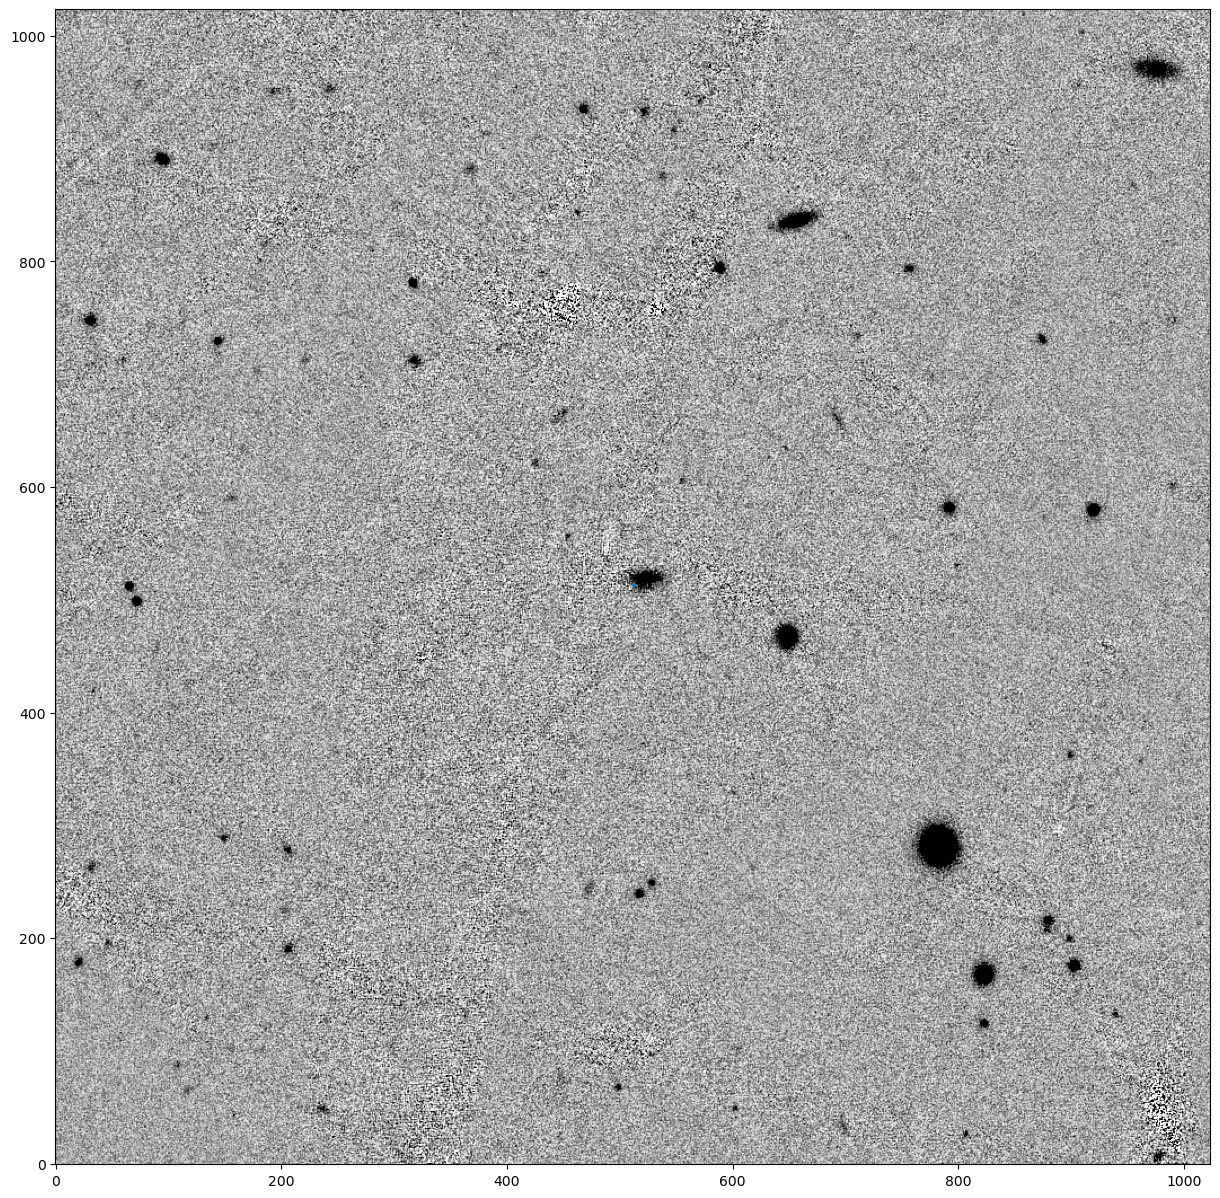

In [670]:
## see the image
fig = plt.figure(figsize=(15,15))

norm = simple_norm(sn_data, 'linear', percent=99)
plt.imshow(sn_data, norm=norm, origin='lower',cmap='Greys')
sn_x, sn_y = sn_wcs[0].all_world2pix(tra, tdec, 1)
plt.scatter(sn_x, sn_y, marker='+', s=10)

In [671]:
## define host galaxy detection threshold above the background
thres = 3
npix = 20
threshold = thres*sn_bkg.background_rms
segm_deblend = detect_sources(sn_data, threshold, npixels=npix)

# background error
err = calc_total_error(sn_data, sn_bkg.background_rms, sn_header['CELL.GAIN'] * sn_header['EXPTIME'])
cat = SourceCatalog(sn_data, segm_deblend, error=err, kron_params=(2.5,1.4))
tbl = cat.to_table()

## PS1 zeropoint for r band is 24.68 (https://iopscience.iop.org/article/10.1088/0004-637X/756/2/158/pdf Table 1)
m_app = -2.5*np.log10(cat.kron_flux) + 24.68

## the equation from Edo's paper
sigma_m = (1/(0.33*np.log(10)))*10**(0.33*(m_app-24)-2.44)

## r50 is an array of half light radii for all detected objects in the frame
r50 = cat.fluxfrac_radius(0.5).value * 0.25

## r is an array of distance from the SN location to the centroid of each detected object
r = np.sqrt((tbl['xcentroid'].data-sn_x)**2+(tbl['ycentroid'].data-sn_y)**2)*0.25

## No uncertainties, so this is the effective radius for each object
R_e = np.sqrt(r**2+4*r50**2)

## Probability of chance coincidence
P_cc = 1-np.exp(-np.pi*R_e**2*sigma_m)

## object with the lowest probability -- this is the "host"
print(P_cc)
host_p = np.nanmin(P_cc)

## get the properties of the host
host = cat.get_label(np.nanargmin(P_cc)+1)
host_tbl = host.to_table()
host_x, host_y = (host.xcentroid,host.ycentroid)

[4.54371467e-02 3.34113427e-03 1.78165824e-02 8.42226059e-02
 4.42708764e-02 3.03326702e-02 1.32327221e-02 2.05369629e-02
 2.08794325e-04 2.59682132e-04 2.28844904e-02 2.89223833e-02
 1.70188296e-05 1.02120622e-02 8.41531494e-03 1.53642231e-02
 4.08260968e-02 4.92629911e-02 3.64993053e-02 2.19656549e-02
 6.87303467e-03 3.60606022e-02 4.90961573e-03 2.86737500e-02
 2.82328278e-02 1.34809207e-02]


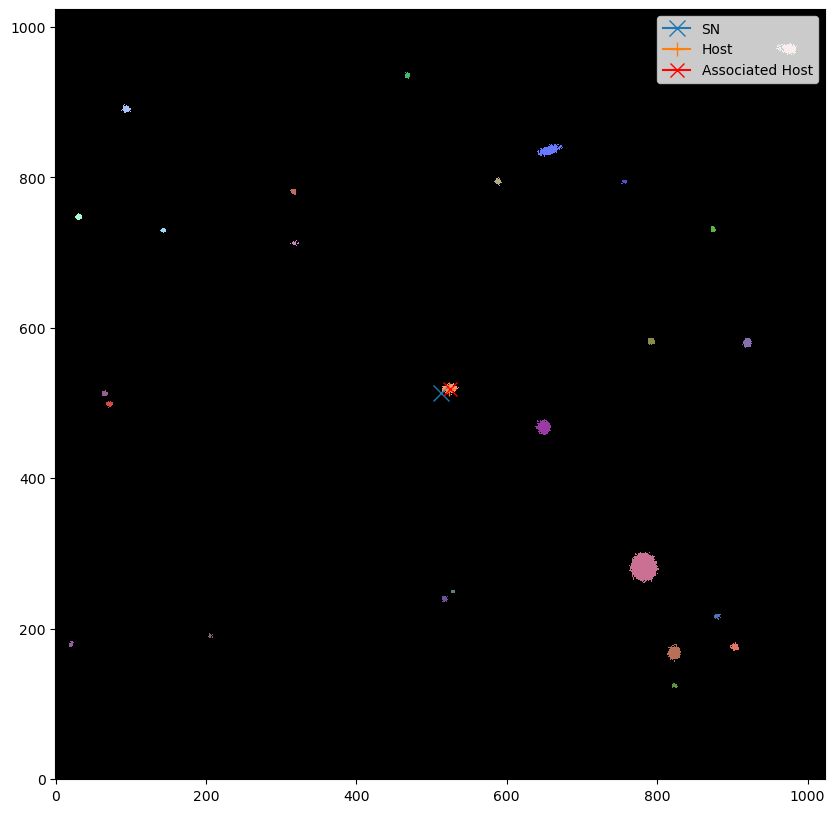

In [672]:
## plot it

fig, ax = plt.subplots(1,1,figsize=(10,10))
norm = simple_norm(segm_deblend, 'power', percent=99)
plt.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap,interpolation='nearest')
plt.plot(sn_x, sn_y,marker='x',markersize=12, label='SN')
plt.plot(host_x, host_y,marker='+',markersize=10, label='Host')

gal_x, gal_y = sn_wcs[0].all_world2pix(gal_ra, gal_dec, 1)
plt.plot(gal_x, gal_y, marker='x',markersize=10, label='Associated Host', color='red')

## uncomment to zoom in
# plt.xlim(host_x-20,host_x+20)
# plt.ylim(host_y-20,host_y+20)
plt.legend()
plt.show()

In [673]:
shutil.rmtree('ps1_dir')

In [674]:
print("{:.1f} s".format(time.time()-t0))

6.7 s


In [675]:
brian_host_ra, brian_host_dec = sn_wcs[0].all_pix2world(host_x, host_y, 1)

Size:  240


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


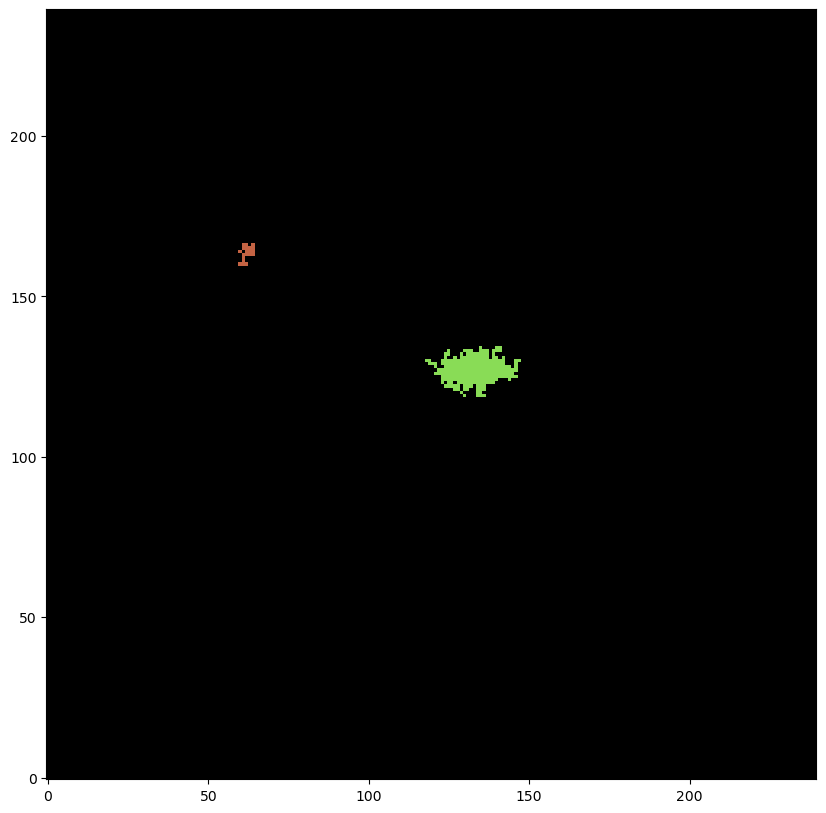

SN @ ([230.73162499999998], [56.43083333333333]): 	 	 2 candidates found with P_cc < 0.1
My Search: ([230.73024112], [56.43124419])
Correct (array(230.73027078), array(56.43121372))
HERE 
 (230.73023843483696, 230.7390453588543) 
 (56.43123738315529, 56.433757537696785) 
 (1.810900539889193e-05, 0.003724354111653838)


TypeError: make_query() got an unexpected keyword argument 'search_radius'

In [676]:
import os
import sys
import numpy as np
from astropy.table import Table
import requests
import pickle
import shutil
from io import StringIO
import wget
import urllib
from pathlib import Path
from astropy.io import fits
from astropy import table
from astropy.wcs import WCS
from glob import glob
from astropy.visualization import simple_norm
from astropy.stats import SigmaClip
from astropy.coordinates import Angle
from astropy.io import ascii
from astropy.cosmology import Planck18 as cosmo  # Using the Planck 2018 cosmology
from astropy import units as u
from photutils.segmentation import detect_threshold, detect_sources, SourceCatalog
from photutils.background import Background2D, MADStdBackgroundRMS
from photutils.utils import circular_footprint, calc_total_error
sys.path.append('/Users/adamboesky/Research/ay98/Weird_Galaxies/matching_hosts')
from match_panstarrs_sne import make_query


sys.path.append('/n/home04/aboesky/berger/Weird_Galaxies')
sys.path.append('/Users/adamboesky/Research/ay98/Weird_Galaxies')
from logger import get_clean_logger

# os.mkdir = 'ps1_dir'
PS1FILENAME = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
FITSCUT = "https://ps1images.stsci.edu/cgi-bin/fitscut.cgi"
CLUSTER = False

if CLUSTER:
    PATH_TO_STORAGE = '/n/holystore01/LABS/berger_lab/Users/aboesky/Weird_Galaxies/'
else: 
    PATH_TO_STORAGE = '/Users/adamboesky/Research/ay98/clean_data'


def get_current_data():
    """Get the current place in our data."""
    # Grab the sne data
    with open(os.path.join(PATH_TO_STORAGE, 'sn_coords_clean.csv'), 'rb') as f:
        sne = pickle.load(f)

    # Create empty columns
    cols = ['raMean', 'decMean'] + [f'{filt}MeanApMag' for filt in ['g', 'r', 'i', 'z', 'y']] + [f'{filt}MeanApMagErr' for filt in ['g', 'r', 'i', 'z', 'y']]  # desired columns
    sne[cols] = np.NaN
    n = len(sne)

    # If the associate table already exists, pick up from the end of the already associated hosts
    print('Getting the index of the last host in saved table')
    if os.path.exists(os.path.join(PATH_TO_STORAGE, 'panstarrs_hosts_pcc.ecsv')):

        # Get the index of the last already associated SN
        all_res = ascii.read(os.path.join(PATH_TO_STORAGE, 'panstarrs_hosts_pcc.ecsv'), delimiter=' ', format='ecsv')
        last_ra, last_dec = all_res[-1]['SN_ra'], all_res[-1]['SN_dec']
        col_types = {col: all_res[col].dtype for col in all_res.columns}
        for i, sn_ra, sn_dec in zip(range(n), sne['ra'], sne['dec']):
            # Put angles in a dictionary
            dec_deg = Angle(f'{sn_dec.split(",")[0]} degrees').deg
            ra_deg = Angle(sn_ra.split(',')[0], unit='hourangle').deg

            tol = 1E-10  # tolerance for SNe being the same
            if abs(ra_deg - last_ra) < tol and abs(dec_deg - last_dec) < tol:
                print(f'Search going to pick up from row {i} / {n}')
                last_searched_ind = i
                break

    else:
        print('No table exists, starting cone search from beginning')
        last_searched_ind = 0
        col_types = None
        all_res = None

    return sne, last_searched_ind, col_types, all_res


# modified from https://outerspace.stsci.edu/display/PANSTARRS/PS1+Image+Cutout+Service
def get_images(tra, tdec, size_arcsec=None, filters="grizy", format="fits", imagetypes="stack"):
    """Query ps1filenames.py service for multiple positions to get a list of images
    This adds a url column to the table to retrieve the cutout.

    tra, tdec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    format = data format (options are "fits", "jpg", or "png")
    imagetypes = list of any of the acceptable image types.  Default is stack;
        other common choices include warp (single-epoch images), stack.wt (weight image),
        stack.mask, stack.exp (exposure time), stack.num (number of exposures),
        warp.wt, and warp.mask.  This parameter can be a list of strings or a
        comma-separated string.

    Returns an astropy table with the results
    """

    # If there was no redshift, we default to a 60 arcsecond search
    if size_arcsec is None:
        size_arcsec = 60
    size = np.ceil(size_arcsec * (1 / 0.25)).astype(int)   # size in pixels
    print('Size: ', size)

    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    # if imagetypes is a list, convert to a comma-separated string
    if not isinstance(imagetypes,str):
        imagetypes = ",".join(imagetypes)
    # put the positions in an in-memory file object
    cbuf = StringIO()
    cbuf.write('\n'.join(["{} {}".format(ra, dec) for (ra, dec) in zip(tra, tdec)]))
    cbuf.seek(0)
    # use requests.post to pass in positions as a file... 3 tries in the query
    for attempt in range(3):
        try:
            r = requests.post(PS1FILENAME, data=dict(filters=filters, type=imagetypes), files=dict(file=cbuf))
            r.raise_for_status()
            tab = Table.read(r.text, format="ascii")

            tab["url"] = ["{}?red={}&format={}&x={}&y={}&size={}&wcs=1&imagename={}".format(FITSCUT,
                                                                                            filename,
                                                                                            format,
                                                                                            ra,
                                                                                            dec,
                                                                                            size,
                                                                                            'cutout_'+shortname) 
                        for (filename,ra,dec,shortname) in zip(tab["filename"],tab["ra"],tab["dec"],tab['shortname'])]
            break
        except Exception as e:
            print(f'Exception {attempt} encountered getting image: {e}. Continuing...')
            tab = None
            continue

    return tab


def background_subtracted(data):
    """Estimate background to get background subtracted data and background error in counts."""
    sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
    threshold = detect_threshold(data, nsigma=3, sigma_clip=sigma_clip)
    segment_img = detect_sources(data, threshold, npixels=4)
    if segment_img is None:
        return None, None
    footprint = circular_footprint(radius=3)
    mask = segment_img.make_source_mask(footprint=footprint)
    xsize = round(data.shape[1]/100)
    ysize = round(data.shape[0]/100)
    try:
        bkg = Background2D(data, (ysize,xsize), filter_size=(3, 3),mask=mask,
                        bkgrms_estimator = MADStdBackgroundRMS(sigma_clip))
    except:
        return None, None
    sub_data = data-bkg.background
    return sub_data, bkg


def get_host_coords(sn_ra: float, sn_dec: float, sn_z: float) -> (float, float):
    """Get the host coordinates for a set of sne coords.
    Args:
        sn_ras: The right acensions of the supernova.
        sn_decs: The declinations of the supernova.
    Returns:
        1. The RAs of the host candidates.
        2. The DECs of the host candidates.
        3. The probability of chance coincidence of the candidates.
        NOTE: The returned arrays are sorted in increasing P_cc
    """

    # Get the arcseconds that we want to search for. We will use within 100kpc
    if not np.isnan(sn_z):
        distance = cosmo.angular_diameter_distance(sn_z)
        angular_size_rad = (100 * u.kpc / distance).decompose() * u.rad
        angular_size_arcsec = (angular_size_rad.to(u.arcsec)).value
    else:
        angular_size_arcsec = None

    # Get the PS1 info for those positions
    table = get_images(sn_ra, sn_dec, size_arcsec=angular_size_arcsec, filters='r')

    # Arrays to put vals in
    host_ras = []
    host_decs = []
    host_P_ccs = []

    if table is not None:
        # Download the cutout to your directory
        ps1_dirpath = os.path.join(PATH_TO_STORAGE, 'ps1_dir')
        if not os.path.exists(ps1_dirpath):
            os.mkdir(ps1_dirpath)

        try:
            wget.download(table['url'][0],out=ps1_dirpath)
        except urllib.error.HTTPError as e:
            print('v bad')
            return host_ras, host_decs, host_P_ccs

        ## Load the data
        sn_image = glob(os.path.join(ps1_dirpath, '*.fits'))[0]
        sn = fits.open(sn_image)
        sn_data, sn_bkg = background_subtracted(sn[0].data)

        # If we can't get the SN out
        if sn_data is None and sn_bkg is None:
            return host_ras, host_decs, host_P_ccs

        sn_header = sn[0].header
        sn_wcs = WCS(sn_header)
        sn.close()

        sn_x, sn_y = sn_wcs.all_world2pix(sn_ra, sn_dec, 1)
        thres = 3
        npix = 20
        threshold = thres*sn_bkg.background_rms
        segm_deblend = detect_sources(sn_data, threshold, npixels=npix)
        fig, ax = plt.subplots(1,1,figsize=(10,10))
        plt.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap,interpolation='nearest')
        plt.show()


        if segm_deblend is not None:  # if we detect sources

            # background error
            err = calc_total_error(sn_data, sn_bkg.background_rms, sn_header['CELL.GAIN'] * sn_header['EXPTIME'])
            cat = SourceCatalog(sn_data, segm_deblend, error=err, kron_params=(2.5,1.4))
            tbl = cat.to_table()

            ## PS1 zeropoint for r band is 24.68 (https://iopscience.iop.org/article/10.1088/0004-637X/756/2/158/pdf Table 1)
            m_app = -2.5*np.log10(cat.kron_flux) + 24.68

            ## the equation from Edo's paper
            sigma_m = (1/(0.33*np.log(10)))*10**(0.33*(m_app-24)-2.44)

            ## r50 is an array of half light radii for all detected objects in the frame
            r50 = cat.fluxfrac_radius(0.5).value * 0.25

            ## r is an array of distance from the SN location to the centroid of each detected object
            r = np.sqrt((tbl['xcentroid'].data-sn_x)**2+(tbl['ycentroid'].data-sn_y)**2)*0.25

            ## No uncertainties, so this is the effective radius for each object
            R_e = np.sqrt(r**2+4*r50**2)

            ## Probability of chance coincidence
            P_cc = 1-np.exp(-np.pi*R_e**2*sigma_m)

            # The indices of the host candidates
            host_inds = np.where(P_cc < 0.1)[0]

            if len(host_inds) > 0:  # If there are any host candidates!!!
                for host_ind in host_inds:

                    # Get host coords
                    host = cat.get_label(host_ind+1)
                    host_x, host_y = (host.xcentroid,host.ycentroid)
                    host_ra, host_dec = sn_wcs.all_pix2world(host_x, host_y, 1)

                    # Append values
                    host_ras.append(float(host_ra))
                    host_decs.append(float(host_dec))
                    host_P_ccs.append(P_cc[host_ind])

            # Sort candidates in increasing P_cc
            combined = sorted(zip(host_P_ccs, host_ras, host_decs))
            if combined:
                host_P_ccs, host_ras, host_decs = zip(*combined)
            else:
                # Handle the empty case appropriately
                host_P_ccs, host_ras, host_decs = [], [], []
            # host_P_ccs, host_ras, host_decs = zip(*combined)

            # Clean up dir
            shutil.rmtree(ps1_dirpath)

    return host_ras, host_decs, host_P_ccs


def get_mean_of_strs(s: str) -> float:
    """Get the mean of a string of floats."""
    if isinstance(s, float):
        return s
    else:
        arr = np.array(s.split(',')).astype(float)
        return np.nanmean(arr)





def match_host_sne():
    """Match the sne to host galaxies in the panstarrs databse and save files."""

    # Necessary params
    sr = 6/3600  # search radius [deg]

    # Convert SN coords to degrees
    sn_ra_ang = tra
    sn_dec_ang = tdec

    # Get the host coordinates
    host_ras, host_decs, host_P_ccs = get_host_coords(sn_ra_ang, sn_dec_ang, np.NaN)
    print(f'SN @ {sn_ra_ang, sn_dec_ang}: \t \t {len(host_ras)} candidates found with P_cc < 0.1')
    print(f'My Search: {gal_ra, gal_dec}')
    print(f'Correct {brian_host_ra, brian_host_dec}')

    # Search through all the candidates (in increasing order of probability) and get data
    print('HERE', '\n', host_ras, '\n', host_decs, '\n', host_P_ccs)
    for host_ra, host_dec in zip(host_ras, host_decs):
        res = make_query(host_ra, host_dec, search_radius=sr, sn_ra=sn_ra_ang, sn_dec=sn_dec_ang)
        if res is not None:
            print(host_ra, host_dec)
    # make_query(host_ras[0], host_decs[0], search_radius=sr, sn_ra=sn_ra_ang, sn_dec=sn_dec_ang)


if __name__=='__main__':
    match_host_sne()

In [ ]:
combined = sorted(zip([2,1,3], [2,1,3], [2,1,3]))
a,b,c = zip(*combined)
print(a)
print(b)
print(c)

(1, 2, 3)
(1, 2, 3)
(1, 2, 3)
